## Sentiment Classification AU Reviews Data (BOW, non-Deep Learning)

This notebook covers two good approaches to perform sentiment classification - Naive Bayes and Logistic Regression. We will train AU reviews data on both.

As a rule of thumb, reviews that are 3 stars and above are **positive**, and vice versa.

In [1]:
%pip install spacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install spacy_langdetect

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 16.9 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
import gensim
import spacy
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm

In [6]:
RANDOM_SEED = 33

In [7]:
reviews = pd.read_pickle("assets/au_reviews.pkl")
reviews.head()

,date,review,rating,app
0,2020-07-11,I’ve been a DoorDash user for a while now and ...,3,DoorDash
1,2020-05-26,I ordered a meal for delivery and after 1:30 I...,1,DoorDash
2,2020-09-03,"I have gotten three orders from Doordash, all ...",1,DoorDash
3,2021-08-13,The delay and customer support I experienced w...,1,DoorDash
4,2021-11-01,I have had countless problems using DoorDash s...,1,DoorDash


In [8]:
reviews['label'] = np.where(reviews['rating'] >= 3, 0, 1)

In [9]:
reviews.head()

,date,review,rating,app,label
0,2020-07-11,I’ve been a DoorDash user for a while now and ...,3,DoorDash,0
1,2020-05-26,I ordered a meal for delivery and after 1:30 I...,1,DoorDash,1
2,2020-09-03,"I have gotten three orders from Doordash, all ...",1,DoorDash,1
3,2021-08-13,The delay and customer support I experienced w...,1,DoorDash,1
4,2021-11-01,I have had countless problems using DoorDash s...,1,DoorDash,1


## 1. Data Processing

Check the dataset size:

In [10]:
print(len(reviews))

626377


And the type of apps:

In [11]:
app_list = list(reviews['app'].unique())
app_list

['DoorDash', 'UberEats', 'Deliveroo', 'MenuLog', 'Grubhub']

Let's also get a sense of our dataset's balance

In [12]:
reviews['label'].value_counts(normalize=True)

0    0.662462
1    0.337538
Name: label, dtype: float64

In [13]:
# By app

for app in app_list:
    print(reviews[reviews['app'] == app]['label'].value_counts(normalize=True))

0    0.760423
1    0.239577
Name: label, dtype: float64
0    0.648032
1    0.351968
Name: label, dtype: float64
0    0.651189
1    0.348811
Name: label, dtype: float64
0    0.682461
1    0.317539
Name: label, dtype: float64
0    0.56053
1    0.43947
Name: label, dtype: float64


Across the board the distribution of positive and negative reviews are quite consistent between the apps. Overall, there's an imbalance in our dataset, with positive reviews making for 75% of the dataset. Let's also check for null values.

In [14]:
reviews.isnull().sum()

date       0
review    54
rating     0
app        0
label      0
dtype: int64

In [15]:
reviews = reviews.dropna()

In [16]:
df_proc = reviews.copy()
df_proc.drop(columns=['date', 'rating', 'app'], inplace=True)
df_proc.head()

,review,label
0,I’ve been a DoorDash user for a while now and ...,0
1,I ordered a meal for delivery and after 1:30 I...,1
2,"I have gotten three orders from Doordash, all ...",1
3,The delay and customer support I experienced w...,1
4,I have had countless problems using DoorDash s...,1


For AU dataset we won't be filtering out non-English reviews. It's likely that this makes up for a very small proportion of the dataset.

In [17]:
df_proc.to_csv('reviews_au_filtered.csv')

In [18]:
X = df_proc['review']
y = df_proc['label']

We will split the dataset into `train`, `test`, and `dev`, with 80%, 10%, 10% ratio, respectively.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED)

In [20]:
len(X_train)

501058

In [21]:
len(X_dev)

62633

In [22]:
len(X_test)

62632

In [23]:
X_train.iloc[0]

'Nice apk but some restaurants supply bad quality food'

In [24]:
X_test.iloc[0]

'dope food app'

## 2.1 Bag-of-Words Approach on Naive Bayes & Logistic Regression

This section explores the use of bag of words as feature extraction. But first, let's have a look at the token frequencies.

In [25]:
# Fill this with any token (with anything in it!) for tokens separated by whitespace
ws_tokens = Counter()

# Fill this one with tokens separated by whitespace but constisting only of tokens
# that are totally made of alphanumeric characters (you can use the \w character
# class in making the regex)

alpha_ws_tokens = Counter()

# Fill this one with the tokens separated by *word boundaries* (not white space) that consist
# of alphanumeric characters (use \w again)
alpha_re_tokens = Counter()
for review in tqdm(X_train):
    ws_review = review.split()
    ws_tokens.update(ws_review)
    # Note: use fullmatch() as it anchor both the start and end of str. match() won't work.
    alpha_ws_tokens.update([re.fullmatch(r'\w+', word).group() for word in ws_review if re.fullmatch(r'\w+', word) != None])
    alpha_re_tokens.update(re.findall(r'\w+', review))

100%|██████████| 501058/501058 [00:20<00:00, 24120.74it/s]


In [26]:
print(len(ws_tokens))
print(len(alpha_ws_tokens))
print(len(alpha_re_tokens))

221265
89320
103276


In [27]:
top_100 = alpha_re_tokens.most_common(100)
top_100

[('the', 266849),
 ('to', 255887),
 ('and', 227093),
 ('I', 209984),
 ('a', 134290),
 ('it', 132177),
 ('app', 128152),
 ('is', 113100),
 ('order', 105566),
 ('my', 103000),
 ('for', 92448),
 ('food', 86756),
 ('t', 86739),
 ('of', 77926),
 ('you', 73536),
 ('service', 71883),
 ('not', 66109),
 ('delivery', 65577),
 ('they', 62087),
 ('in', 60542),
 ('have', 58140),
 ('but', 56996),
 ('was', 56483),
 ('that', 55889),
 ('this', 55238),
 ('with', 55091),
 ('me', 52427),
 ('on', 52145),
 ('good', 50797),
 ('time', 49030),
 ('use', 46261),
 ('s', 46192),
 ('no', 40860),
 ('are', 40347),
 ('get', 38224),
 ('from', 37020),
 ('your', 35031),
 ('an', 34730),
 ('so', 34695),
 ('i', 34579),
 ('when', 34508),
 ('be', 33970),
 ('can', 32035),
 ('or', 30616),
 ('Uber', 29980),
 ('customer', 29608),
 ('Great', 29182),
 ('up', 29072),
 ('The', 27958),
 ('very', 27315),
 ('had', 26841),
 ('Good', 26628),
 ('at', 26498),
 ('as', 25374),
 ('just', 25343),
 ('great', 24541),
 ('if', 24290),
 ('It', 23879

Lots of stopwords, as expected.

In [28]:
x = list(range(100))
y = [word_tup[1] for word_tup in top_100]

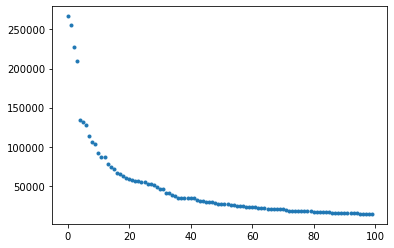

In [29]:
ax = plt.plot(x, y, '.')
#plt.yscale('log')
#plt.xscale('log')

And unexpectedly, the word frequency distribution also follows Zipf's law as well. What that means is that we can essentially remove uncommon words, without worrying that they will affect performance. We will also need to remove stopwords, and add unigrams and bigrams as features.

In [30]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=500, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)

In [31]:
print(X_train_bow.shape)

(501058, 1389)


In [32]:
X_dev_bow = vectorizer.transform(X_dev)

In [33]:
def train_model(clf):
    print("_" * 80)
    print("Training: ")
    clf.fit(X_train_bow, y_train)
    y_dev_pred = clf.predict(X_dev_bow)
    
    score = accuracy_score(y_dev, y_dev_pred)
    print("accuracy:   %0.3f" % score)
    
    print("classification report:")
    print(classification_report(y_dev, y_dev_pred))
    
    print("confusion matrix:")
    print(confusion_matrix(y_dev, y_dev_pred))
    print("Training Complete")
    print()
    
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, y_dev_pred

It's training time! We'll start with a few dummy classifiers, followed by Naive Bayes and Logistic Regression.

In [34]:
for clf, name in (
    (DummyClassifier(strategy='uniform', random_state=RANDOM_SEED), "Uniform Classifier"),
    (DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED), "Most Frequent Classifier"),
):
    print("=" * 80)
    print("Training Results - Dummy Classifiers")
    print(name)
    mod = train_model(clf)

Training Results - Dummy Classifiers
Uniform Classifier
________________________________________________________________________________
Training: 
accuracy:   0.499
classification report:
              precision    recall  f1-score   support

           0       0.66      0.50      0.57     41413
           1       0.34      0.50      0.40     21220

    accuracy                           0.50     62633
   macro avg       0.50      0.50      0.49     62633
weighted avg       0.55      0.50      0.51     62633

confusion matrix:
[[20678 20735]
 [10627 10593]]
Training Complete

Training Results - Dummy Classifiers
Most Frequent Classifier
________________________________________________________________________________
Training: 
accuracy:   0.661
classification report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.80     41413
           1       0.00      0.00      0.00     21220

    accuracy                           0.66     62633
   

/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [35]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.899
classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     41413
           1       0.84      0.87      0.85     21220

    accuracy                           0.90     62633
   macro avg       0.88      0.89      0.89     62633
weighted avg       0.90      0.90      0.90     62633

confusion matrix:
[[37812  3601]
 [ 2724 18496]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.853
classification report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     41413
           1       0.82      0.72      0.77     21220

    accuracy                           0.85     62633
   macro avg   

The baseline results are quite promising, with both MultinomialNB and Logistic Regression achieving 0.85 on macro F1-score. This means that the bag-of-word approach is a rather solid approach for sentiment classification. It's also interesting to see that while MultinomialNB has a rather balanced number of false pos and false neg, BernoulliNB and ComplementNB are different. BernoulliNB has a much higher number of fps, while ComplementNB has a much higher number of fns.

Also, according to https://web.stanford.edu/~jurafsky/slp3/4.pdf, using binary NB (BernoulliNB) may improve predictive performance, as whether a word occurs or not seems to matter more than its frequency. But in this case, BernoulliNB does not outperform other Naive Bayes methods. We'll come back to this in a second.

Let's take a look at a few of mis-classifications for both Naive Bayes and Logistic Regression.

In [36]:
# Create a dataframe for mis-classifications
def create_mis_classification_df(name):
    mis_class = pd.DataFrame(X_dev)
    mis_class['Actual'] = y_dev
    mis_class['Predicted'] = preds[name]
    mis_class = mis_class[mis_class['Actual'] != mis_class['Predicted']]
    return mis_class

In [37]:
mis_class_multi = create_mis_classification_df('MultinomialNB')
mis_class_bernoulli = create_mis_classification_df('BernoulliNB')
mis_class_complement = create_mis_classification_df('ComplementNB')
mis_class_logreg = create_mis_classification_df('Logistic Regression')

In [38]:
mis_class_multi.sample(10).values

array([["orders don't get double checked and are frequently missing items or just not correct",
        0, 1],
       ['Because I said so', 0, 1],
       ['Ratas', 1, 0],
       ['I always use this app, but recently we found out Uber is overcharging restaurants, taking opportunity of the Pendemic. I shall not use this services again until they justify there actions.',
        1, 0],
       ['Dont stay stuck while hungry. This app will keep you fed!', 0,
        1],
       ['Bakwas service', 1, 0],
       ['You can trust UberEATS', 0, 1],
       ["Only a stupid person will get trapped with Uber Eats . A pass for food to be delivered that will cost you a Arm and Leg ! Thank you But No Thank you Keep the food I will get my own food and it's not worth it . I love KAM KAU CHINESE FOOD they are not even on the list ... Thanks Uber but you won't hit my pocket 👎",
        1, 0],
       ["The actual reason why I'm fat", 0, 1],
       ["For the most part. Good service. Sometimes restaurants don'

In [39]:
mis_class_bernoulli.sample(10).values

array([["Love doordash, but this one doordasher was bad. Didn't get all of what I had order, said he was going get what I was missing, didn't come back.So I still use doordash though.",
        0, 1],
       ['The service was great at first during COVID. Now, I constantly get lost or late orders. They point the finger to the store and the store points the finger to DoorDash.',
        1, 0],
       ["Overall a convenient app + service, but delivery time can be hit or miss. A lot of drivers have trouble finding the right house/door despite obvious signs and clearly typed instructions for every house I've ordered from. The driver GPS lags pretty bad too. Other than that, most drivers are very polite (and apologetic when they can't find me lol).",
        0, 1],
       ['This is mt 2nd time ordering first order was 20 min past est delievry. So i am giving them another try',
        0, 1],
       ["I think I got same order I was expecting fried white egg rice & others. Think you have me sa

In [40]:
mis_class_complement.sample(10).values

array([['abe pehele app thik karo phir playstore par dalo', 1, 0],
       ['Expensive deals than usual and no discounts and off', 1, 0],
       ['1. month', 0, 1],
       ['Good but i am unable to change my delivery address even if I add a new one the old is always the default',
        0, 1],
       ['Not good ,', 1, 0],
       ["It's alright but when my order got cancelled I didn't get any notification which was pretty annoying. Editing an address is also a bit clunky. Moreover, in some of the menus it's not obvious if an item is an extra or not: like with a local burger place you can add toppings and beef patty but it doesn't say if those are extras so if I don't add them does it mean my burger would come without any patty or toppings? Just for comparison, JustEat makes it clear in the same restaurant's menu.",
        0, 1],
       ["I could tip the drivers a lot better if the applications fees weren't so high",
        1, 0],
       ['Good, easy to use app. However, the customer s

In [41]:
mis_class_logreg.sample(10).values

array([['Sometimes an hour late with cold food', 0, 1],
       ['this app keeps bugging me to rate it everytime i use it, so im doing this hoping to never get notifications again. Small issue is that if i buy an uber eats subscription, and it says "Spend 80 to get free delivery" restaurants with somethin close to that price will make their prices like R79.90',
        0, 1],
       ['Create', 0, 1],
       ['Not bad noice size', 0, 1],
       ['Come back uber eats in India we are missing you a lot', 0, 1],
       ["All's good but I cannot fathom how they manage to operate legally in Sri Lanka without having a Hotline or any customer support system to get immediate help from!",
        0, 1],
       ["Can always count on uber to get me food that don't offer delivery.",
        0, 1],
       ["Just ordered for the first time and were very excited. Our driver had difficulties dropping off the food and called us, perfect. However our driver then drive off with our food and marked the deliv

Really interesting. Looking at the results, there are a few cases of mis-classifications:
- Reviews that contain negation expressions, eg "not okay" is classified as a positive review when in reality it should be negative. BoW approach makes it hard for ML model to recognize this kind of expressions.
- Reviews that are mis-classified due to rating. Eg a customer may write something negative but give 3 stars. It's tricky in this case because it's a caveat of our dataset.
- Some mis-classification is the ML model being weirdly off, eg ComplementNB classified a "Good" review as negative, or reviews containing the word 'hate' gets classified as positive.
- Contextual awareness is important and this is something that bag-of-word approaches cannot address. For example the sentence 'Very good. Expensive delivery charge though' gets classified as negative likely because of the word expensive, while in reality this is a positive review.

### 2.1 Reduce min_df

We set a min frequency cap of 500. What happens if we reduce this cap to 100?

In [42]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [43]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.907
classification report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     41413
           1       0.84      0.89      0.87     21220

    accuracy                           0.91     62633
   macro avg       0.89      0.90      0.90     62633
weighted avg       0.91      0.91      0.91     62633

confusion matrix:
[[37866  3547]
 [ 2276 18944]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.856
classification report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     41413
           1       0.83      0.72      0.77     21220

    accuracy                           0.86     62633
   macro avg   

Slight bump in performance, but at the expense of longer training time. 

### 2.2 Not use stopwords removal

In [44]:
vectorizer = TfidfVectorizer(min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [45]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.912
classification report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     41413
           1       0.84      0.91      0.88     21220

    accuracy                           0.91     62633
   macro avg       0.90      0.91      0.90     62633
weighted avg       0.92      0.91      0.91     62633

confusion matrix:
[[37816  3597]
 [ 1903 19317]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.828
classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.87     41413
           1       0.79      0.68      0.73     21220

    accuracy                           0.83     62633
   macro avg   

Performance improved, surprisingly.

### 2.3 Set max_df

In [46]:
vectorizer = TfidfVectorizer(min_df=100, max_df=5000, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [47]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.911
classification report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     41413
           1       0.87      0.86      0.87     21220

    accuracy                           0.91     62633
   macro avg       0.90      0.90      0.90     62633
weighted avg       0.91      0.91      0.91     62633

confusion matrix:
[[38713  2700]
 [ 2873 18347]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.842
classification report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89     41413
           1       0.82      0.68      0.75     21220

    accuracy                           0.84     62633
   macro avg   

Not much changes from stopwords removal.

### 2.4 Clip frequency at 1

Earlier, we see that there isn't any performance with BernoulliNB as compared to other methods. But what if we clip the frequency at the feature processing level? Luckily, sklearn tfidf has a `binary` parameters that allows us to do that.

In [48]:
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1,1))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [49]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.901
classification report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     41413
           1       0.83      0.89      0.86     21220

    accuracy                           0.90     62633
   macro avg       0.89      0.90      0.89     62633
weighted avg       0.90      0.90      0.90     62633

confusion matrix:
[[37626  3787]
 [ 2388 18832]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.823
classification report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     41413
           1       0.77      0.68      0.72     21220

    accuracy                           0.82     62633
   macro avg   

### 2.5 Tune Logistic Regression Params

So far, LogReg performs the best in terms of macro F1 score. In this section, we'll try tuning the performance of Logistic Regression, using the best Tfidf tuning result above.

In [50]:
vectorizer = TfidfVectorizer(min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [51]:
clf = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=3000, random_state=RANDOM_SEED)
param_grid = {'C' : np.logspace(-4, 4, 20)}


print("=" * 80)
print("LogReg Grid Search")
clf = GridSearchCV(clf, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train_bow, y_train)
print(clf.best_params_)
y_dev_pred = clf.predict(X_dev_bow)
score = accuracy_score(y_dev, y_dev_pred)
print("accuracy:   %0.3f" % score)
print("classification report:")
print(classification_report(y_dev, y_dev_pred))
print("confusion matrix:")
print(confusion_matrix(y_dev, y_dev_pred))
print("Training Complete")
print()

LogReg Grid Search
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 1.623776739188721}
accuracy:   0.926
classification report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     41413
           1       0.86      0.94      0.90     21220

    accuracy                           0.93     62633
   macro avg       0.91      0.93      0.92     62633
weighted avg       0.93      0.93      0.93     62633

confusion matrix:
[[38078  3335]
 [ 1298 19922]]
Training Complete

